# Social Network Analysis

**In this notebook, we will work on a social network analysis. It contains two parts: <br>
1) Based on a email network in a company, predict whether an employer is on management position (achieving AUC 0.97) <br>
2) Make prediction of the probability for two employees get connected in the future (achieving AUC)**

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Company Emails

We will be working with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [2]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))


Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


### Part A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.


## Load Dataset and build related features



In [3]:
df = pd.DataFrame(G.nodes())
df['salary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
df['clustering'] = pd.Series(nx.clustering(G))
df['degree'] = pd.Series(G.degree())
df['betweenness'] = pd.Series(nx.betweenness_centrality(G, normalized = True, endpoints = False))
df['closeness']=pd.Series(nx.closeness_centrality(G, normalized=True))


In [4]:
df['salary'].value_counts() # imbalanced, class weight around {1:5}

0.0    634
1.0    119
Name: salary, dtype: int64

In [5]:
df['salary'].head(10)

0    0.0
1    NaN
2    NaN
3    1.0
4    1.0
5    NaN
6    1.0
7    0.0
8    NaN
9    0.0
Name: salary, dtype: float64

In [6]:
df = df.set_index([0])
df_test = df[df.salary.isnull()]
df = df.dropna()
feature=['clustering', 'degree', 'betweenness','closeness']


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df[feature+['salary']], hue='salary')

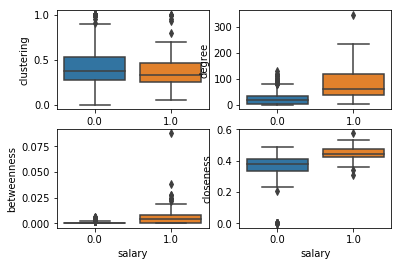

In [8]:
for i in range(len(feature)):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x='salary', y=feature[i], data=df)



In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV  
from sklearn.metrics import auc, roc_curve

X_train, X_test, y_train, y_test = train_test_split(df[feature], df['salary'], random_state=10, stratify=df['salary'])
clf=RandomForestClassifier(class_weight = 'balanced')

param_grid = {'n_estimators': [50, 300, 500,700], 'max_depth' : [3,4,5,6]}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5,scoring='f1')
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'max_depth': 4, 'n_estimators': 50}
0.7206110325683303


In [10]:
from sklearn.model_selection import cross_val_score

clf_optimized =RandomForestClassifier(n_estimators=CV_rfc.best_params_['n_estimators'], 
                           max_depth=CV_rfc.best_params_['max_depth'], class_weight = 'balanced')
scores = cross_val_score(clf_optimized, df[feature], df['salary'],
                         scoring='f1', cv=5)
print('f1 score:', scores.mean(), scores.std())
scores = cross_val_score(clf_optimized, df[feature], df['salary'],
                         scoring='roc_auc', cv=5)
print('roc_auc score:', scores.mean(), scores.std())





f1 score: 0.6664213195159486 0.11542851689944887
roc_auc score: 0.972674339620591 0.008481899487228382


In [11]:
from sklearn.metrics import confusion_matrix
clf_optimized.fit(X_train, y_train)
print('confusion matrix', confusion_matrix(y_test,clf_optimized.predict(X_test)))

confusion matrix [[155   4]
 [  9  21]]


### Part B - New Connections Prediction

For the last part of this assignment, we will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [12]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(5)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0


To accomplish this, we need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.


In [13]:
df2 = future_connections
df2['PreferentialAttachment'] = [i[2] for i in nx.preferential_attachment(G, df2.index)]
df2['CommonNeighbors'] = df2.index.map(lambda node: len(list(nx.common_neighbors(G, node[0], node[1]))))
df2['jaccard'] = [i[2] for i in nx.jaccard_coefficient(G, df2.index)]
df2['resource_allocation'] = [i[2] for i in nx.resource_allocation_index(G, df2.index)]
df_test = df2[df2['Future Connection'].isnull()]
df2 = df2.dropna()
   


In [14]:
df2['Future Connection'].value_counts() # Imbalanced Dataset

0.0    337002
1.0     29332
Name: Future Connection, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV  
from sklearn.metrics import auc, roc_curve

feature=['PreferentialAttachment','CommonNeighbors','jaccard', 'resource_allocation']
X_train, X_test, y_train, y_test = train_test_split(df2[feature], df2['Future Connection'],
                                                    random_state=11, stratify=df2['Future Connection'])
clf=RandomForestClassifier(class_weight = 'balanced')

param_grid = {'n_estimators': [50, 300, 500], 'max_depth' : [3,4,6]}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3,scoring='f1')
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'max_depth': 6, 'n_estimators': 500}
0.59793567433832


In [16]:
from sklearn.model_selection import cross_val_score

clf_optimized =RandomForestClassifier(n_estimators=CV_rfc.best_params_['n_estimators'], 
                           max_depth=CV_rfc.best_params_['max_depth'], class_weight = 'balanced')
scores = cross_val_score(clf_optimized, df2[feature], df2['Future Connection'],
                         scoring='f1', cv=3)
print('f1 score:', scores.mean(), scores.std())
scores = cross_val_score(clf_optimized, df2[feature], df2['Future Connection'],
                         scoring='roc_auc', cv=3)
print('roc_auc score:', scores.mean(), scores.std())





f1 score: 0.5973385269031337 0.004478319544455011
roc_auc score: 0.9095423669586039 0.003765396129089091
